In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)
from dermsynth3d.datasets.datasets import (
    ImageDataset,
)
from scripts.inference import inference_segmentation
from dermsynth3d.losses.metrics import (
    compute_results_segmentation,
)
from dermsynth3d.utils.image import float_img_to_uint8

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
n_classes = 1
seg_model = deeplabv3_resnet50(pretrained=True)
seg_model.classifier = DeepLabHead(2048, n_classes)
seg_model.load_state_dict(torch.load("/path/to/trained/model"), strict=False)

<All keys matched successfully>

In [5]:
seg_model = seg_model.to(device)
seg_model.eval();

In [6]:
img_size = (256, 256)

In [7]:
# Assumes the model was pretrained using these values.
preprocess_input = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img_preprocess = A.Compose(
    [
        preprocess_input,
    ]
)

# To force a resize of the input image.
resize_func = A.Resize(height=img_size[0], width=img_size[1])
# Perform spatial augmentation on both the image and mask.
spatial_augment = A.Compose(
    [
        resize_func,
    ]
)

<h2>Foot Ulcer Segmentation Challenge (FUSeg) Images</h2>

https://github.com/uwm-bigdata/wound-segmentation/tree/master/data/Foot%20Ulcer%20Segmentation%20Challenge

See instructions to download the images.

Update `dir_wounds` to the directory containing the FUSeg images and labels.

In [8]:
# Where the FUSeg images are stored.
dir_wounds = "../data/FUSeg/test"
dir_wounds_images = os.path.join(dir_wounds, "images")
dir_wounds_targets = os.path.join(dir_wounds, "labels")
wounds_test_ds = ImageDataset(
    dir_images=dir_wounds_images,
    dir_targets=dir_wounds_targets,
    name="wounds",
    image_extension=".png",
    target_extension=".png",
    image_augment=None,
    spatial_transform=spatial_augment,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
)
wounds_test_dataloader = DataLoader(wounds_test_ds, batch_size=1, shuffle=False)
print(len(wounds_test_ds))

200


<h3>Save the predictions and compute the results</h3>

In [10]:
dir_seg_preds_wounds_test = "../data/FUSeg/preds"
wounds_test = inference_segmentation(
    max_imgs=len(wounds_test_dataloader),
    model=seg_model,
    dataloader=wounds_test_dataloader,
    device=device,
    save_to_disk=True,
    return_values=True,
    dir_save_seg_preds=dir_seg_preds_wounds_test,
)

100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


In [11]:
wounds_test_df = pd.DataFrame(
    compute_results_segmentation(
        wounds_test_ds, dir_seg_preds_wounds_test, pred_ext=".png"
    )
)
# Skin condition.
print(
    "IoU: {:.2f} \nDice: {:.2f}".format(
        wounds_test_df.iou.mean(),
        wounds_test_df.dice.mean(),
    )
)

IoU: 0.39 
Dice: 0.51


In [15]:
idx = 10
file_id = wounds_test["file_ids"][idx][0]

<h3>Result Visualization</h3>

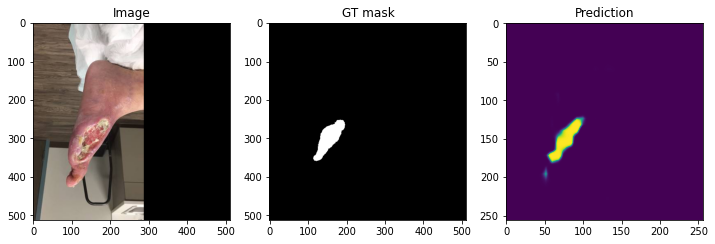

In [19]:
plt.figure(figsize=(12, 20))
ax1 = plt.subplot(1, 3, 1)
image = wounds_test_ds.image(file_id)
ax1.set_title("Image")
plt.imshow(image)

ax2 = plt.subplot(1, 3, 2)
gt_segmentation = wounds_test_ds.target(file_id)
ax2.set_title("GT mask")
plt.imshow(gt_segmentation)

ax3 = plt.subplot(1, 3, 3)
predicted_seg = wounds_test["segs"][idx]
ax3.set_title("Prediction")
plt.imshow(predicted_seg)